t= 24.99900000000757776

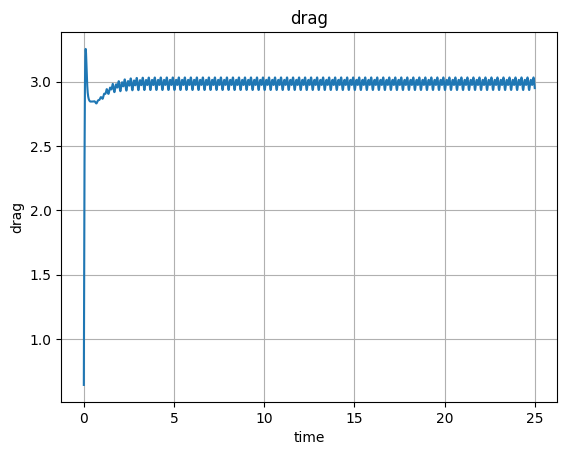

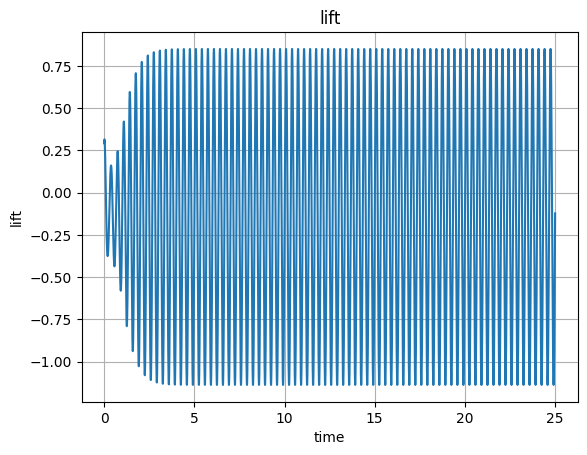

In [19]:
# import libarries, define geometry and generate mesh
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()
shape.edges.name="cyl"
shape.edges.Min(X).name="inlet"
shape.edges.Max(X).name="outlet"
shape.edges.Min(Y).name="wall"
shape.edges.Max(Y).name="wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=1/8)).Curve(3) 
n  = specialcf.normal(mesh.dim)
# viscosity
nu = 0.001

k = 3
V = VectorH1(mesh,order=k, dirichlet="wall|cyl|inlet")
Q = H1(mesh,order=k-1)
X = V*Q

gfu = GridFunction(X)
velocity, pressure = gfu.components
# parabolic inflow at bc=1:
uin = CoefficientFunction((1.5*4*y*(0.41-y)/(0.41*0.41),0))
velocity.Set(uin, definedon=mesh.Boundaries("inlet"))

# Draw(velocity,mesh,"u")
# Draw(pressure,mesh,"p")

(u,p), (v,q) = X.TnT()

a = BilinearForm(X)
stokes = (nu*InnerProduct(grad(u),grad(v))-div(u)*q-div(v)*p)*dx
a += stokes
a.Assemble()

f = LinearForm(X)   
f.Assemble()

res = f.vec - a.mat*gfu.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu.vec.data += inv_stokes * res

dt = 0.001
# matrix for implicit part of IMEX(1) scheme:
mstar = BilinearForm(X)
mstar += InnerProduct(u,v)*dx + dt*stokes
mstar.Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())

conv = BilinearForm(X, nonassemble = True)
conv += (Grad(u) * u) * v * dx

tend = 0
gfut = GridFunction(gfu.space,multidim=0)
time_vals, drag_x_vals, drag_y_vals = [],[],[]

# implicit Euler/explicit Euler splitting method:
tend += 25
gfut.AddMultiDimComponent(gfu.vec)
t = 0; cnt = 0
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    # print(conv.mat)
    res = (a.mat + conv.mat)* gfu.vec
    gfu.vec.data -= dt * inv * res

    t = t + dt; cnt += 1
    
    res = (a.mat + conv.mat) * gfu.vec
    drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
    drag_y_vals.append(InnerProduct(res, drag_y_test.vec) )
    time_vals.append(t)
    
    if cnt % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)

# Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True,
#       min=0, max=1.9, autoscale=False, vectors = True)
# Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True,
#       min=-0.5, max=1, autoscale=False)

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

In [20]:
# 计算 drag 和 lift 的统计量
drag_max = np.max(drag_x_vals)
drag_min = np.min(drag_x_vals)
drag_mean = np.mean(drag_x_vals)

lift_max = np.max(drag_y_vals)
lift_min = np.min(drag_y_vals)
lift_mean = np.mean(drag_y_vals)

# 打印结果
print(f"Drag: max = {drag_max:.6f}, min = {drag_min:.6f}, mean = {drag_mean:.6f}")
print(f"Lift: max = {lift_max:.6f}, min = {lift_min:.6f}, mean = {lift_mean:.6f}")

Drag: max = 3.253640, min = 0.643937, mean = 2.979642
Lift: max = 0.850045, min = -1.137753, mean = -0.142434


In [48]:
# import libarries, define geometry and generate mesh
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
shape = Rectangle(2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()
shape.edges.name="cyl"
shape.edges.Min(X).name="inlet"
shape.edges.Max(X).name="outlet"
shape.edges.Min(Y).name="wall"
shape.edges.Max(Y).name="wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=1/8)).Curve(3) 

# viscosity
nu = 0.001

k = 3
V = VectorH1(mesh,order=k, dirichlet="wall|cyl|inlet")
Q = H1(mesh,order=k-1)
X = V*Q

gfu = GridFunction(X)
gfu_D = GridFunction(X)
velocity, pressure = gfu.components
velocity_D, pressure_D = gfu_D.components
# parabolic inflow at bc=1:
uin = CoefficientFunction((1.5*4*y*(0.41-y)/(0.41*0.41),0))
velocity_D.Set(uin, definedon=mesh.Boundaries("inlet"))

# Draw(velocity,mesh,"u")
# Draw(pressure,mesh,"p")

(u,p), (v,q) = X.TnT()

a = BilinearForm(X)
stokes = (nu*InnerProduct(grad(u),grad(v))-div(u)*q-div(v)*p)*dx
a += stokes
a.Assemble()
f = LinearForm(X)   
f.Assemble()

res = f.vec - a.mat*gfu_D.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu.vec.data = gfu_D.vec + inv_stokes * res

# Draw(velocity,mesh,"u")

dt = 0.001
mstar = BilinearForm(X)
mstar += InnerProduct(u,v)*dx + dt*stokes
mstar.Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())

conv = BilinearForm(X, nonassemble = True)
conv += InnerProduct(u,v)*dx - dt * (Grad(u) * u) * v * dx

tend = 0
gfut = GridFunction(gfu.space,multidim=0)

tend += 1
gfut.AddMultiDimComponent(gfu.vec)
t = 0; cnt = 0
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res = conv.mat * gfu.vec - mstar.mat * gfu_D.vec
    gfu.vec.data = gfu_D.vec + inv * res

    t = t + dt; cnt += 1
    mean_p = Integrate(pressure, mesh)
    domain_vol = Integrate(1, mesh)
    mean_val = mean_p / domain_vol
    
    # 2. 创建 offset 向量
    ones = pressure.vec.CreateVector()
    ones[:] = 1.0
    offset = mean_val * ones
    
    # 3. 减去 offset，实现零均值
    pressure.vec.data -= offset
    if cnt % 50 == 0:
        gfut.AddMultiDimComponent(gfu.vec)

Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True,
      min=0, max=1.9, autoscale=False, vectors = True)
Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True,
      min=-0.5, max=1, autoscale=False)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

t= 0.999000000000000876

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

# 1. 增量形式圆柱绕流

t= 4.999000000000004676
3.151432411900075 0.6224979121928095


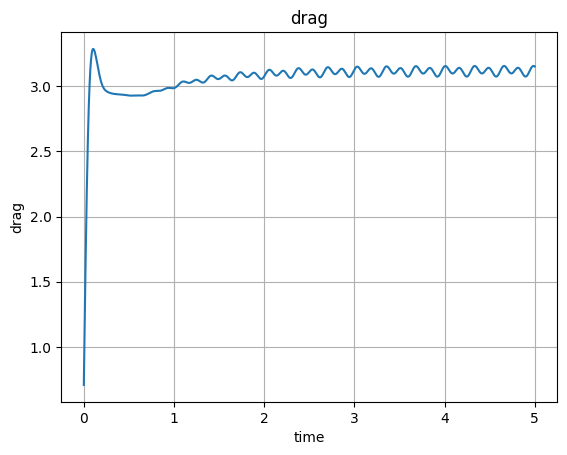

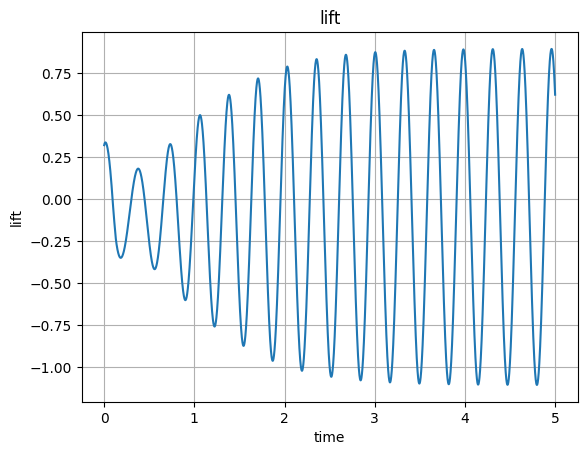

In [17]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/32)).Curve(3) # 三阶多项式拟合曲线
# n = specialcf.normal(mesh.dim)                       
n  = specialcf.normal(mesh.dim)        # 外法向
Id = Id(mesh.dim)                       # 单位张量  (或  Id(2)  )
rho = 1                                 # ρ=1 已隐含在 ν 里
D   = 0.1                               # 圆柱直径（用来算系数）
Uref = 1.5                              # 入口平均速度
# # 绘制物理域及计算域
# DrawGeo(shape); 
# Draw(mesh); # OCCGeometry会根据绘制图像复杂性生成不同粗细的网格拟合（如圆附近网格会更细）

nu = 0.001
k = 3 # 空间阶数
dt = 0.001 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet")
Q = H1(mesh, order = k-1) # 未指明的边界默认为自然边界条件（在弱形式中会体现为零Neumann边界条件）
X = V * Q # 定义速度场与压力场的耦合空间

gfu = GridFunction(X) # 设置GridFunction作为解域，用于存储解作为后续初值使用
velocity, pressure = gfu.components # X由V，P组成，gfu.components即为[V，P]
uin = CF((1.5*4*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
velocity.Set(uin, definedon = mesh.Boundaries("inlet"))

# gfu_D.vec.data.FV().NumPy()[X.FreeDofs()] = 0

drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

# # 分别绘制速度场和压力场处置
# Draw(velocity);
# Draw(pressure);

# 设置Trial和Test函数
(u,p),(v,q) = X.TnT()

a = BilinearForm((nu*InnerProduct(grad(u),grad(v)) - div(v)*p - div(u)*q)*dx).Assemble()
f = LinearForm(X).Assemble() # 默认为0

res = f.vec - a.mat * gfu.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu.vec.data += inv_stokes * res

# # 绘制stokes的解（NS的初值）
# sceneu = Draw(velocity,mesh,"u")
# scenep = Draw(pressure,mesh,"p")

mstar = BilinearForm((InnerProduct(u, v) + dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())
r1 = BilinearForm(X, nonassemble = True)
r1 += dt * (- ((Grad(u) * u) * v)) * dx
r2 = BilinearForm(dt * (InnerProduct(u, v) * dx)).Assemble()
r3 = BilinearForm(- dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q) * dx).Assemble()
f = LinearForm(X).Assemble()
conv = BilinearForm(X, nonassemble = True)
conv += (((Grad(u) * u) * v)) * dx

t = 0
i = 0
tend = 5
gfut = GridFunction(gfu.space,multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)
gfu1 = GridFunction(X)
gfu2 = GridFunction(X)
gfu3 = GridFunction(X)

while t < tend - 0.5 * dt:
    print ("\rt=", t, end="")
    r1.Assemble()
    conv.Assemble()
    f.vec.data = r1.mat * gfu.vec
    gfu1.vec.data = inv * f.vec

    f.vec.data = r2.mat * gfu.vec
    gfu2.vec.data = inv * f.vec

    f.vec.data = r3.mat * gfu.vec
    # f.vec.data = r3.mat * gfu.vec - dt * a.mat * gfu_D.vec
    gfu3.vec.data = gfu.vec + inv * f.vec
    
    # 当前速度
    velocity = gfu.components[0]
    velocity1 = gfu1.components[0]
    velocity2 = gfu2.components[0]
    velocity3 = gfu3.components[0]
    
    # 构造 F(uⁿ) = (u · ∇)u
    du = grad(velocity)
    F_un = CoefficientFunction((
        velocity[0]*du[0,0] + velocity[1]*du[0,1],
        velocity[0]*du[1,0] + velocity[1]*du[1,1]
    ))
    F_u = GridFunction(X)
    conv_u = F_u.components[0]
    conv_u.Set(F_un)

    # 计算每个项
    a11 = Integrate(InnerProduct(velocity, velocity), mesh) - Integrate(InnerProduct(velocity, velocity1), mesh)
    a12 = - Integrate(InnerProduct(velocity, velocity2), mesh)
    a21 = - Integrate(InnerProduct(F_un, velocity1), mesh)
    a22 = Integrate(InnerProduct(velocity, velocity), mesh) - Integrate(InnerProduct(F_un, velocity2), mesh)
    b1  = Integrate(InnerProduct(velocity, velocity3), mesh)
    b2  = Integrate(InnerProduct(F_un, velocity3), mesh) - Integrate(0.5 * InnerProduct(velocity, velocity) * InnerProduct(velocity, n), mesh, BND)
    # b2  = InnerProduct(conv_u.vec, velocity3.vec)
    # print(a11,a12,a21,a22)
    # print(b1,b2)
    
    alpha = (b1 * a22 - a12 * b2) / (a11 * a22 - a12 * a21)
    beta = (a11 * b2 - b1 * a21) / (a11 * a22 - a12 * a21)
    # print()
    # print(alpha, beta)
    # break
    gfu.vec.data = alpha * gfu1.vec + beta * gfu2.vec + gfu3.vec
    
    mean_p = Integrate(pressure, mesh)
    domain_vol = Integrate(1, mesh)
    mean_val = mean_p / domain_vol
    
    # 2. 创建 offset 向量
    ones = pressure.vec.CreateVector()
    ones[:] = 1.0
    offset = mean_val * ones
    
    # 3. 减去 offset，实现零均值
    pressure.vec.data -= offset

    t = t + dt
    i += 1

    res = (a.mat + conv.mat) * gfu.vec
    drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
    drag_y_vals.append(InnerProduct(res, drag_y_test.vec) )
    time_vals.append(t)
    
    if i % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)
print()
print(InnerProduct(res, drag_x_test.vec),InnerProduct(res, drag_y_test.vec))
# Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True, autoscale=False, vectors = True);
# Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True, autoscale=False);

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

In [8]:
import numpy as np

np.savez('cylinder_drag_lift.npz', time=time_vals, drag=drag_x_vals, lift=drag_y_vals)

import os

outdir = r"E:\seminar\ouputdir\Cylinder_Incremention_BDF1"
os.makedirs(outdir, exist_ok=True)  # 自动创建目录
file_path = os.path.join(outdir, "1000_8_1000")
vel_cf = CoefficientFunction((
    gfu.components[0][0],
    gfu.components[0][1],
    0.0  # 补上 Z 分量，使其为 3D vector
))
pres_cf = gfu.components[1]

vtkout = VTKOutput(
    mesh,
    coefs = [vel_cf, pres_cf],
    names = ["velocity", "pressure"],
    filename = file_path,
    subdivision = 2
)

nframes = len(gfut.vecs)  # 多帧数量

for i in range(nframes):
    # 提取第i帧的解
    gfu.vec.data = gfut.vecs[i]  # 恢复到第i帧
    outname = vtkout.Do(time=i)
print("已写出：", outname)
# 加载方式
# data = np.load('cylinder_drag_lift.npz')
# drag = data['drag']
# lift = data['lift']

已写出： E:\seminar\ouputdir\Cylinder_Incremention_BDF1\1000_8_1000_step00250


In [16]:
import numpy as np

# 加载数据
data = np.load('cylinder_drag_lift.npz')

# 提取数组
time = data['time']
drag = data['drag']
lift = data['lift']

# 计算 drag 和 lift 的统计量
drag_max = np.max(drag)
drag_min = np.min(drag)
drag_mean = np.mean(drag)

lift_max = np.max(lift)
lift_min = np.min(lift)
lift_mean = np.mean(lift)

# 打印结果
print(f"Drag: max = {drag_max:.6f}, min = {drag_min:.6f}, mean = {drag_mean:.6f}")
print(f"Lift: max = {lift_max:.6f}, min = {lift_min:.6f}, mean = {lift_mean:.6f}")


Drag: max = 3.253862, min = 0.646143, mean = 2.982733
Lift: max = 0.828096, min = -1.113845, mean = -0.140874


In [15]:
import numpy as np

# 载入保存的数据
data = np.load('cylinder_drag_lift.npz')
time = data['time']
drag = data['drag']
lift = data['lift']

# 选取稳定的时间段 t ∈ [8, 25]
mask = (time >= 8.0) & (time <= 25.0)
drag_stable = drag[mask]
lift_stable = lift[mask]

# 计算统计量
drag_min = np.min(drag_stable)
drag_max = np.max(drag_stable)
drag_mean = np.mean(drag_stable)

lift_min = np.min(lift_stable)
lift_max = np.max(lift_stable)
lift_mean = np.mean(lift_stable)

# 输出结果
print(f"Drag: max = {drag_max:.6f}, min = {drag_min:.6f}, mean = {drag_mean:.6f}")
print(f"Lift: max = {lift_max:.6f}, min = {lift_min:.6f}, mean = {lift_mean:.6f}")


Drag: max = 3.034300, min = 2.943587, mean = 2.991235
Lift: max = 0.828096, min = -1.113845, mean = -0.140461


## 1.1 CN1

t= 0.999000000000000876

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

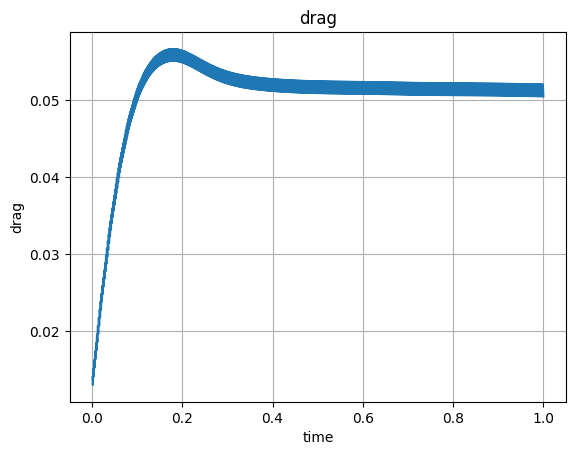

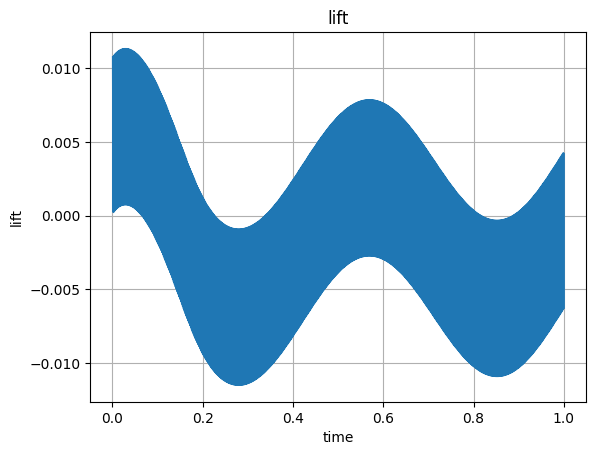

In [19]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/8)).Curve(3) # 三阶多项式拟合曲线
# n = specialcf.normal(mesh.dim)                       
n  = specialcf.normal(mesh.dim)        # 外法向
Id = Id(mesh.dim)                       # 单位张量  (或  Id(2)  )
rho = 1                                 # ρ=1 已隐含在 ν 里
D   = 0.1                               # 圆柱直径（用来算系数）
Uref = 1.5                              # 入口平均速度

# # 绘制物理域及计算域
# DrawGeo(shape); 
# Draw(mesh); # OCCGeometry会根据绘制图像复杂性生成不同粗细的网格拟合（如圆附近网格会更细）

nu = 0.001
k = 3 # 空间阶数
dt = 0.001 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet")
Q = H1(mesh, order = k-1) # 未指明的边界默认为自然边界条件（在弱形式中会体现为零Neumann边界条件）
X = V * Q # 定义速度场与压力场的耦合空间

gfu = GridFunction(X) # 设置GridFunction作为解域，用于存储解作为后续初值使用
velocity, pressure = gfu.components # X由V，P组成，gfu.components即为[V，P]
uin = CF((4*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
velocity.Set(uin, definedon = mesh.Boundaries("inlet"))

def F(u):
    # 任意你需要的表达式
    velocity = u.components[0]
    return exp(velocity) + sin(velocity)

# gfu_D.vec.data.FV().NumPy()[X.FreeDofs()] = 0

drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

# # 分别绘制速度场和压力场处置
# Draw(velocity);
# Draw(pressure);

# 设置Trial和Test函数
(u,p),(v,q) = X.TnT()

a = BilinearForm((nu*InnerProduct(grad(u),grad(v)) - div(v)*p - div(u)*q)*dx).Assemble()
f = LinearForm(X).Assemble() # 默认为0

res = f.vec - a.mat * gfu.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu.vec.data += inv_stokes * res

# # 绘制stokes的解（NS的初值）
# sceneu = Draw(velocity,mesh,"u")
# scenep = Draw(pressure,mesh,"p")

mstar = BilinearForm((2*InnerProduct(u, v) + dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())
r1 = BilinearForm(X, nonassemble = True)
r1 += dt * (- ((Grad(u) * u) * v)) * dx
f_expr = F(gfu)
r2 = LinearForm(dt * (InnerProduct(f_expr, v) * dx)).Assemble()
r3 = BilinearForm(- dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q) * dx).Assemble()
f = LinearForm(X).Assemble()
Fu = GridFunction(X)

t = 0
i = 0
tend = 1
gfut = GridFunction(gfu.space,multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)
gfu1 = GridFunction(X)
gfu2 = GridFunction(X)
gfu3 = GridFunction(X)
gfu_old = GridFunction(X)

while t < tend - 0.5 * dt:
    print ("\rt=", t, end="")
    r1.Assemble()
    f.vec.data = r1.mat * gfu.vec
    gfu1.vec.data = inv * f.vec

    # velocityu = Fu.components[0]
    # velocityu.Set(1/gfu.components[0])
    f.vec.data = r2.vec
    gfu2.vec.data = inv * f.vec

    f.vec.data = r3.mat * gfu.vec
    # f.vec.data = r3.mat * gfu.vec - dt * a.mat * gfu_D.vec
    gfu3.vec.data = gfu.vec + inv * f.vec
    
    # 当前速度
    velocity1 = gfu1.components[0]
    velocity2 = gfu2.components[0]
    velocity3 = gfu3.components[0]
    
    # 构造 F(uⁿ) = (u · ∇)u
    du = grad(velocity)
    F_un = CoefficientFunction((
        velocity[0]*du[0,0] + velocity[1]*du[0,1],
        velocity[0]*du[1,0] + velocity[1]*du[1,1]
    ))
    F_u = GridFunction(X)
    conv_u = F_u.components[0]
    conv_u.Set(F_un)

    # velocityu.Set(1/gfu.components[0])
    # 计算每个项
    a11 = Integrate(InnerProduct(F(gfu), velocity), mesh) - Integrate(InnerProduct(F(gfu), velocity1), mesh)
    a12 = - Integrate(InnerProduct(F(gfu), velocity2), mesh)
    a21 = - Integrate(InnerProduct(F_un, velocity1), mesh)
    a22 = Integrate(InnerProduct(F(gfu), velocity), mesh) - Integrate(InnerProduct(F_un, velocity2), mesh)
    b1  = Integrate(InnerProduct(F(gfu), velocity3), mesh)
    b2  = Integrate(InnerProduct(F_un, velocity3), mesh) - Integrate(0.5 * InnerProduct(velocity, velocity) * InnerProduct(velocity, n), mesh, BND)
    # b2  = InnerProduct(conv_u.vec, velocity3.vec)
    # print(a11,a12,a21,a22)
    # print(b1,b2)
    
    alpha = (b1 * a22 - a12 * b2) / (a11 * a22 - a12 * a21)
    beta = (a11 * b2 - b1 * a21) / (a11 * a22 - a12 * a21)
    # print()
    # print(alpha, beta)
    # break
    gfu_old.vec.data = gfu.vec
    gfu_mid.vec.data = alpha * gfu1.vec + beta * gfu2.vec + gfu3.vec
    gfu.vec.data = 2*gfu_mid.vec - gfu_old.vec
    
    mean_p = Integrate(pressure, mesh)
    domain_vol = Integrate(1, mesh)
    mean_val = mean_p / domain_vol
    
    # 2. 创建 offset 向量
    ones = pressure.vec.CreateVector()
    ones[:] = 1.0
    offset = mean_val * ones
    
    # 3. 减去 offset，实现零均值
    pressure.vec.data -= offset

    t = t + dt
    i += 1
    
    grad_v  = Grad(velocity)              # ∇u
    strain  = grad_v + grad_v.trans       # (∇u + ∇uᵀ)
    traction = -pressure * n + nu * (strain * n)   # σ·n
    
    FD = Integrate(traction[0], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 拖曳力
    FL = Integrate(traction[1], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 升力
    
    drag_x_vals.append(FD)
    drag_y_vals.append(FL)
    time_vals.append(t)
    
    if i % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)

Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True, autoscale=False, vectors = True);
Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True, autoscale=False);

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

In [12]:
from ngsolve import *
from ngsolve.webgui import Draw

mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
V1 = H1(mesh, order=2)
V2 = H1(mesh, order=2)
V = FESpace([V1, V2])
gfu = GridFunction(V)

# 只操作第一个分量
gfu1 = GridFunction(V1)
gfu1.Set(1/gfu.components[0])
Draw(gfu1)
Draw(gfu.components[0])

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

# 2. 一般形式圆柱绕流BDF1

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

t= 4.999000000000004676

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

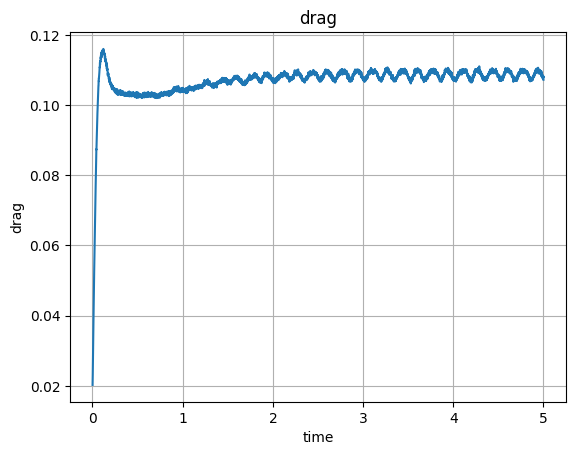

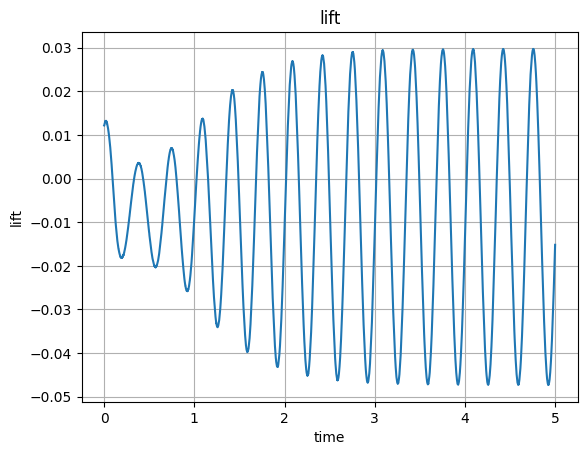

In [28]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/8)).Curve(3) # 三阶多项式拟合曲线
# n = specialcf.normal(mesh.dim)                       
n  = specialcf.normal(mesh.dim)        # 外法向
Id = Id(mesh.dim)                       # 单位张量  (或  Id(2)  )
rho = 1                                 # ρ=1 已隐含在 ν 里
D   = 0.1                               # 圆柱直径（用来算系数）
Uref = 1.5                              # 入口平均速度

# # 绘制物理域及计算域
# DrawGeo(shape); 
# Draw(mesh); # OCCGeometry会根据绘制图像复杂性生成不同粗细的网格拟合（如圆附近网格会更细）

nu = 1/1000       
k = 3 # 空间阶数
dt = 0.001 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet|outlet")
Q = H1(mesh, order = k-1) # 未指明的边界默认为自然边界条件（在弱形式中会体现为零Neumann边界条件）
X = V * Q # 定义速度场与压力场的耦合空间

gfu = GridFunction(X) # 设置GridFunction作为解域，用于存储解作为后续初值使用
gfuD = GridFunction(X)
velocity, pressure = gfu.components # X由V，P组成，gfu.components即为[V，P]
velocityD, pressureD = gfuD.components 
tau = Parameter(0.0)
# uin = CF((sin(pi*tau/8)*6*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
uin = CF((6*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
velocityD.Set(uin, definedon = mesh.Boundaries("inlet|outlet"))
# velocity.Set(uin, definedon = mesh.Boundaries("inlet|outlet"))
# gfu_D.vec.data.FV().NumPy()[X.FreeDofs()] = 0

drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

# # 分别绘制速度场和压力场处置
# Draw(velocity);
# Draw(pressure);

# 设置Trial和Test函数
(u,p),(v,q) = X.TnT()

a = BilinearForm((nu*InnerProduct(grad(u),grad(v)) - div(v)*p - div(u)*q)*dx).Assemble()
f = LinearForm(X).Assemble() # 默认为0

res = f.vec - a.mat * gfuD.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu.vec.data = gfuD.vec + inv_stokes * res
# Draw(velocity)
# # 绘制stokes的解（NS的初值）
# sceneu = Draw(velocity,mesh,"u")
# scenep = Draw(pressure,mesh,"p")

mstar = BilinearForm((InnerProduct(u, v) + dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())
# r1 = BilinearForm(X, nonassemble = True, symmetric=False)
r1 = BilinearForm(X, nonassemble = True)
r1 += dt * (- ((Grad(u) * u) * v)) * dx
r2 = BilinearForm(dt * (InnerProduct(u, v) * dx)).Assemble()
# r3 = BilinearForm(- dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q) * dx).Assemble()
r3 = BilinearForm(InnerProduct(u, v) * dx).Assemble()
f = LinearForm(X).Assemble()

t = 0.0
i = 0
tend = 25
gfut = GridFunction(gfu.space,multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)
gfu1 = GridFunction(X)
gfu2 = GridFunction(X)
gfu3 = GridFunction(X)

while t < tend - 0.5 * dt:
    print ("\rt=", t, end="")
    tau.Set(t)
    velocityD.Set(uin, definedon = mesh.Boundaries("inlet|outlet"))
    r1.Assemble()
    
    f.vec.data = r1.mat * gfu.vec
    gfu1.vec.data = inv * f.vec

    f.vec.data = r2.mat * gfu.vec
    gfu2.vec.data = inv * f.vec

    f.vec.data = r3.mat * gfu.vec - mstar.mat * gfuD.vec
    gfu3.vec.data = gfuD.vec + inv * f.vec
    
    # 当前速度
    velocity = gfu.components[0]
    velocity1 = gfu1.components[0]
    velocity2 = gfu2.components[0]
    velocity3 = gfu3.components[0]
    
    # 构造 F(uⁿ) = (u · ∇)u
    du = grad(velocity)
    F_un = CoefficientFunction((
        velocity[0]*du[0,0] + velocity[1]*du[0,1],
        velocity[0]*du[1,0] + velocity[1]*du[1,1]
    ))
    F_u = GridFunction(X)
    conv_u = F_u.components[0]
    conv_u.Set(F_un)

    # 计算每个项
    a11 = Integrate(InnerProduct(velocity, velocity), mesh) - Integrate(InnerProduct(velocity, velocity1), mesh)
    a12 = - Integrate(InnerProduct(velocity, velocity2), mesh)
    a21 = - Integrate(InnerProduct(F_un, velocity1), mesh)
    a22 = Integrate(InnerProduct(velocity, velocity), mesh) - Integrate(InnerProduct(F_un, velocity2), mesh)
    b1  = Integrate(InnerProduct(velocity, velocity3), mesh)
    b2  = Integrate(InnerProduct(F_un, velocity3), mesh) - Integrate(0.5 * InnerProduct(velocity, velocity) * InnerProduct(velocity, n), mesh, BND)
    # b2  = InnerProduct(conv_u.vec, velocity3.vec)
    # print(a11,a12,a21,a22)
    # print(b1,b2)
    
    alpha = (b1 * a22 - a12 * b2) / (a11 * a22 - a12 * a21)
    beta = (a11 * b2 - b1 * a21) / (a11 * a22 - a12 * a21)
    # print()
    # print(alpha, beta)
    # print()
    # break
    gfu.vec.data = alpha * gfu1.vec + beta * gfu2.vec + gfu3.vec
    
    mean_p = Integrate(pressure, mesh)
    domain_vol = Integrate(1, mesh)
    mean_val = mean_p / domain_vol
    
    # 2. 创建 offset 向量
    ones = pressure.vec.CreateVector()
    ones[:] = 1.0
    offset = mean_val * ones
    
    # 3. 减去 offset，实现零均值
    pressure.vec.data -= offset

    t = t + dt
    i += 1
    # Draw(velocity1)
    # Draw(velocity2)
    # Draw(velocity3)
    # Draw(velocity)
    
    # if i == 10:
    #     break
        
    grad_v  = Grad(velocity)              # ∇u
    strain  = grad_v + grad_v.trans       # (∇u + ∇uᵀ)
    traction = -pressure * n + nu * (strain * n)   # σ·n
    
    FD = Integrate(traction[0], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 拖曳力
    FL = Integrate(traction[1], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 升力
    
    drag_x_vals.append(FD)
    drag_y_vals.append(FL)
    time_vals.append(t)                   # 或 t+dt, 看你想记录哪个时刻
    
    if i % 50 == 0:
        gfut.AddMultiDimComponent(gfu.vec)

Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True, autoscale=False, vectors = True);
# Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True, autoscale=False);

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

In [29]:
import os

outdir = r"E:\seminar\ouputdir\Cylinder_BDF1"
os.makedirs(outdir, exist_ok=True)  # 自动创建目录
file_path = os.path.join(outdir, "1000_8_1000")
vtkout = VTKOutput(
    mesh,
    coefs = [gfu.components[0], gfu.components[1]],
    names = ["velocity", "pressure"],
    filename = file_path,
    subdivision = 2)

nframes = len(gfut.vecs)  # 多帧数量

for i in range(nframes):
    # 提取第i帧的解
    gfu.vec.data = gfut.vecs[i]  # 恢复到第i帧
    outname = vtkout.Do(time=i)
print("已写出：", outname)

已写出： E:\seminar\ouputdir\Cylinder_BDF1\1000_8_1000_step00100


# 3. 一般形式圆柱绕流CN2

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/8)).Curve(3) # 三阶多项式拟合曲线                    
n  = specialcf.normal(mesh.dim)        # 外法向
Id = Id(mesh.dim)                       # 单位张量  (或  Id(2)  )
rho = 1                                 # ρ=1 已隐含在 ν 里
D   = 0.1                               # 圆柱直径（用来算系数）
Uref = 1.5                              # 入口平均速度

# # 绘制物理域及计算域
# DrawGeo(shape); 
# Draw(mesh); # OCCGeometry会根据绘制图像复杂性生成不同粗细的网格拟合（如圆附近网格会更细）

nu = 0.001
k = 3 # 空间阶数
dt = 1/1000 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

# V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet|outlet")
V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet")
Q = H1(mesh, order = k-1) # 未指明的边界默认为自然边界条件（在弱形式中会体现为零Neumann边界条件）
X = V * Q # 定义速度场与压力场的耦合空间

gfu = GridFunction(X) # 设置GridFunction作为解域，用于存储解作为后续初值使用
gfu_mid = GridFunction(X)
gfu_old = GridFunction(X)
gfu_approximation = GridFunction(X)
gfuD = GridFunction(X)
velocity, pressure = gfu.components # X由V，P组成，gfu.components即为[V，P]
velocityD, pressureD = gfuD.components 
# tau = Parameter(0.0)
# uin = CF((sin(pi*tau/8)*6*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
uin = CF((6*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
# velocityD.Set(uin, definedon = mesh.Boundaries("inlet|outlet"))
velocityD.Set(uin, definedon = mesh.Boundaries("inlet"))

# drag_x_test = GridFunction(X)
# drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
# drag_y_test = GridFunction(X)
# drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

# # 分别绘制速度场和压力场处置
# Draw(velocity);
# Draw(pressure);

# 设置Trial和Test函数
(u,p),(v,q) = X.TnT()

a = BilinearForm((nu*InnerProduct(grad(u),grad(v)) - div(v)*p - div(u)*q)*dx).Assemble()
f = LinearForm(X).Assemble() # 默认为0

res = f.vec - a.mat * gfuD.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu.vec.data = gfuD.vec + inv_stokes * res
# Draw(velocity)
# # 绘制stokes的解（NS的初值）
# sceneu = Draw(velocity,mesh,"u")
# scenep = Draw(pressure,mesh,"p")

mstar = BilinearForm((2 * InnerProduct(u, v) + dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())
# r1 = BilinearForm(X, nonassemble = True, symmetric=False)
r1 = BilinearForm(X, nonassemble = True)
r1 += dt * (- ((Grad(u) * u) * v)) * dx
r2 = BilinearForm(dt * (InnerProduct(u, v) * dx)).Assemble()
# r3 = BilinearForm(- dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q) * dx).Assemble()
r3 = BilinearForm(2 * InnerProduct(u, v) * dx).Assemble()
f = LinearForm(X).Assemble()

gfu_old.vec.data = gfu.vec
tmin = 1/1000000
a = BilinearForm((2 * InnerProduct(u, v) + tmin * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
rhs = BilinearForm((2 * InnerProduct(u, v) - tmin * (Grad(u) * u * v)) * dx).Assemble()
inva = a.mat.Inverse(X.FreeDofs())
res = rhs.mat * gfu.vec - a.mat * gfuD.vec
gfu_mid.vec.data = gfuD.vec + inva * res
gfu.vec.data = 2 * gfu_mid.vec - gfu_old.vec

t = 0.0
i = 0
tend = 1
gfut = GridFunction(gfu.space,multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)
gfu1 = GridFunction(X)
gfu2 = GridFunction(X)
gfu3 = GridFunction(X)

In [2]:
while t < tend - 0.5 * dt:
    print ("\rt=", t, end="")
    # tau.Set(t)
    # velocityD.Set(uin, definedon = mesh.Boundaries("inlet|outlet"))
    velocityD.Set(uin, definedon = mesh.Boundaries("inlet"))
    gfu_approximation.components[0].vec.data = 1.5 * gfu.components[0].vec - 0.5 * gfu_old.components[0].vec
    gfu_approximation.components[1].vec.data = gfu.components[1].vec
    
    r1.Assemble()
    
    f.vec.data = r1.mat * gfu_approximation.vec
    gfu1.vec.data = inv * f.vec

    f.vec.data = r2.mat * gfu_approximation.vec
    gfu2.vec.data = inv * f.vec

    f.vec.data = r3.mat * gfu.vec - mstar.mat * gfuD.vec
    gfu3.vec.data = gfuD.vec + inv * f.vec
    
    # 当前速度
    velocity_approximation = gfu_approximation.components[0]
    velocity1 = gfu1.components[0]
    velocity2 = gfu2.components[0]
    velocity3 = gfu3.components[0]
    
    # 构造 F(uⁿ) = (u · ∇)u
    du = grad(velocity_approximation)
    F_un = CoefficientFunction((
        velocity_approximation[0]*du[0,0] + velocity_approximation[1]*du[0,1],
        velocity_approximation[0]*du[1,0] + velocity_approximation[1]*du[1,1]
    ))
    F_u = GridFunction(X)
    conv_u = F_u.components[0]
    conv_u.Set(F_un)

    # 计算每个项
    a11 = Integrate(InnerProduct(velocity_approximation, velocity_approximation), mesh) - Integrate(InnerProduct(velocity_approximation, velocity1), mesh)
    a12 = - Integrate(InnerProduct(velocity_approximation, velocity2), mesh)
    a21 = - Integrate(InnerProduct(F_un, velocity1), mesh)
    a22 = Integrate(InnerProduct(velocity_approximation, velocity_approximation), mesh) - Integrate(InnerProduct(F_un, velocity2), mesh)
    b1  = Integrate(InnerProduct(velocity_approximation, velocity3), mesh)
    b2  = Integrate(InnerProduct(F_un, velocity3), mesh) - Integrate(0.5 * InnerProduct(velocity_approximation, velocity_approximation) * InnerProduct(velocity_approximation, n), mesh, BND)
    
    alpha = (b1 * a22 - a12 * b2) / (a11 * a22 - a12 * a21)
    beta = (a11 * b2 - b1 * a21) / (a11 * a22 - a12 * a21)
    gfu_old.vec.data = gfu.vec
    gfu_mid.vec.data = alpha * gfu1.vec + beta * gfu2.vec + gfu3.vec

    gfu.vec.data = 2 * gfu_mid.vec - gfu_old.vec
    
    mean_p = Integrate(pressure, mesh)
    domain_vol = Integrate(1, mesh)
    mean_val = mean_p / domain_vol
    
    # 2. 创建 offset 向量
    ones = pressure.vec.CreateVector()
    ones[:] = 1.0
    offset = mean_val * ones
    
    # 3. 减去 offset，实现零均值
    pressure.vec.data -= offset

    t = t + dt
    i += 1
        
    grad_v  = Grad(velocity)              # ∇u
    strain  = grad_v + grad_v.trans       # (∇u + ∇uᵀ)
    traction = -pressure * n + nu * (strain * n)   # σ·n
    
    FD = Integrate(traction[0], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 拖曳力
    FL = Integrate(traction[1], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 升力
    
    drag_x_vals.append(FD)
    drag_y_vals.append(FL)
    time_vals.append(t)
    
    if i % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)
        
gfut.AddMultiDimComponent(gfu.vec)

t= 3.998999999999670676

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

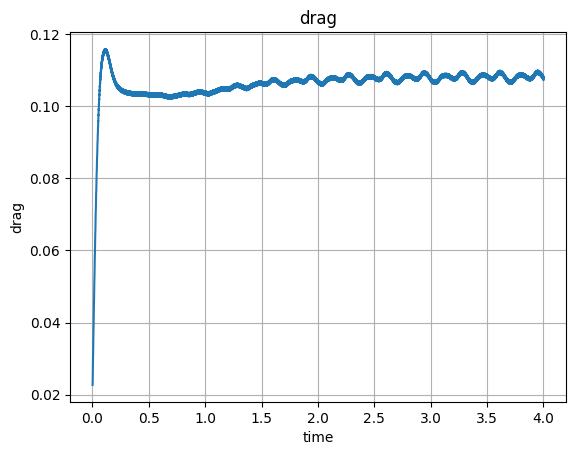

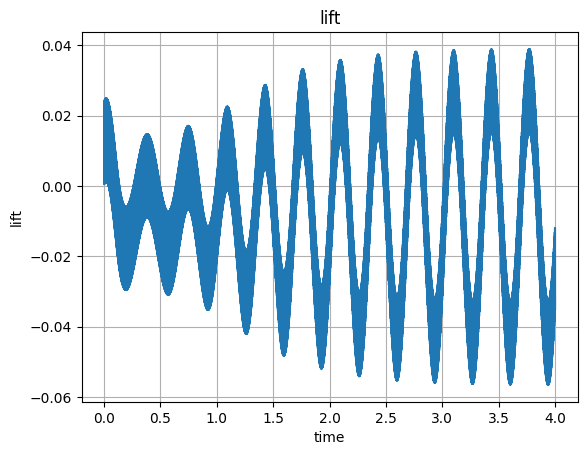

In [3]:
Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True, autoscale=False, vectors = True);
Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True, autoscale=False);

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

In [35]:
import os

outdir = r"E:\seminar\ouputdir\Cylinder_CN2"
os.makedirs(outdir, exist_ok=True)  # 自动创建目录
file_path = os.path.join(outdir, "1000_8_1000")
vtkout = VTKOutput(
    mesh,
    coefs = [gfu.components[0], gfu.components[1]],
    names = ["velocity", "pressure"],
    filename = file_path,
    subdivision = 2)

nframes = len(gfut.vecs)  # 多帧数量

for i in range(nframes):
    # 提取第i帧的解
    gfu.vec.data = gfut.vecs[i]  # 恢复到第i帧
    outname = vtkout.Do(time=i)
print("已写出：", outname)

import numpy as np

np.savez('cylinder_bdf2_drag_lift.npz', time=time_vals, drag=drag_x_vals, lift=drag_y_vals)
# 加载方式
# data = np.load('cylinder_drag_lift.npz')
# drag = data['drag']
# lift = data['lift']

已写出： E:\seminar\ouputdir\Cylinder_CN2\1000_8_1000_step00041


# 4. CN2增量形式

t= 4.999000000000004676

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

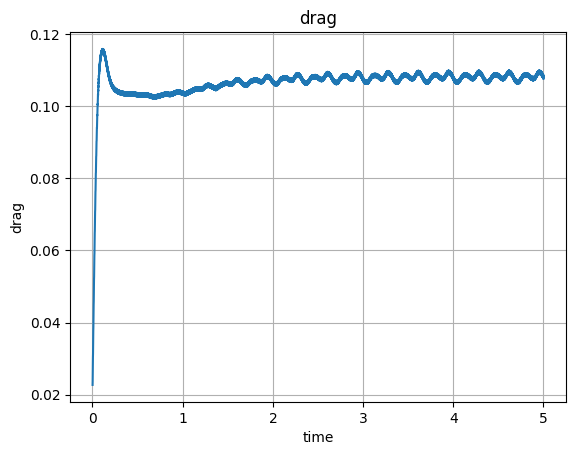

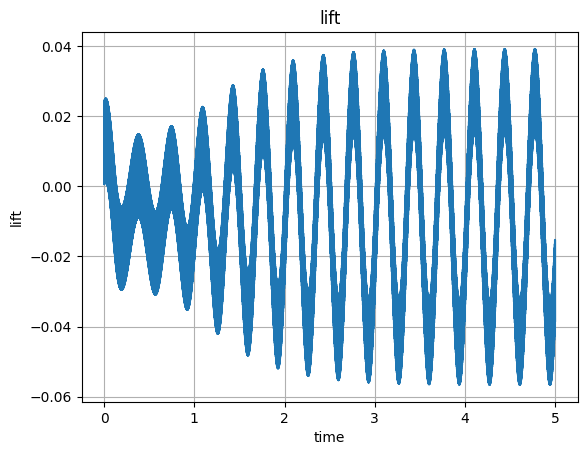

In [37]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/8)).Curve(3) # 三阶多项式拟合曲线
# n = specialcf.normal(mesh.dim)                       
n  = specialcf.normal(mesh.dim)        # 外法向
Id = Id(mesh.dim)                       # 单位张量  (或  Id(2)  )
rho = 1                                 # ρ=1 已隐含在 ν 里
D   = 0.1                               # 圆柱直径（用来算系数）
Uref = 1.5                              # 入口平均速度

# # 绘制物理域及计算域
# DrawGeo(shape); 
# Draw(mesh); # OCCGeometry会根据绘制图像复杂性生成不同粗细的网格拟合（如圆附近网格会更细）

nu = 0.001   
k = 3 # 空间阶数
dt = 1/1000 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet")
Q = H1(mesh, order = k-1) # 未指明的边界默认为自然边界条件（在弱形式中会体现为零Neumann边界条件）
X = V * Q # 定义速度场与压力场的耦合空间

gfu = GridFunction(X) # 设置GridFunction作为解域，用于存储解作为后续初值使用
gfu_mid = GridFunction(X)
gfu_old = GridFunction(X)
gfu_approximation = GridFunction(X)
velocity, pressure = gfu.components # X由V，P组成，gfu.components即为[V，P]
uin = CF((1.5*4*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
velocity.Set(uin, definedon = mesh.Boundaries("inlet"))

# gfu_D.vec.data.FV().NumPy()[X.FreeDofs()] = 0

drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

# # 分别绘制速度场和压力场处置
# Draw(velocity);
# Draw(pressure);

# 设置Trial和Test函数
(u,p),(v,q) = X.TnT()

a = BilinearForm((nu*InnerProduct(grad(u),grad(v)) - div(v)*p - div(u)*q)*dx).Assemble()
f = LinearForm(X).Assemble() # 默认为0

res = f.vec - a.mat * gfu.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu.vec.data += inv_stokes * res

# # 绘制stokes的解（NS的初值）
# sceneu = Draw(velocity,mesh,"u")
# scenep = Draw(pressure,mesh,"p")

mstar = BilinearForm((2 * InnerProduct(u, v) + dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())
r1 = BilinearForm(X, nonassemble = True)
r1 += dt * (- ((Grad(u) * u) * v)) * dx
r2 = BilinearForm(dt * (InnerProduct(u, v) * dx)).Assemble()
r3 = BilinearForm(- dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q) * dx).Assemble()
f = LinearForm(X).Assemble()

gfu_old.vec.data = gfu.vec
tmin = 1/1000000
a = BilinearForm((InnerProduct(u, v) + tmin * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
rhs = BilinearForm((-tmin * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q) - tmin * (Grad(u) * u * v)) * dx).Assemble()
inva = a.mat.Inverse(X.FreeDofs())
res = rhs.mat * gfu.vec
gfu.vec.data += inva * res

t = 0
i = 0
tend = 5
gfut = GridFunction(gfu.space,multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)
gfu1 = GridFunction(X)
gfu2 = GridFunction(X)
gfu3 = GridFunction(X)

while t < tend - 0.5 * dt:
    print ("\rt=", t, end="")
    r1.Assemble()
    gfu_approximation.vec.data = 1.5 * gfu.vec - 0.5 * gfu_old.vec
    f.vec.data = r1.mat * gfu_approximation.vec
    gfu1.vec.data = inv * f.vec

    f.vec.data = r2.mat * gfu_approximation.vec
    gfu2.vec.data = inv * f.vec

    f.vec.data = r3.mat * gfu.vec
    # f.vec.data = r3.mat * gfu.vec - dt * a.mat * gfu_D.vec
    gfu3.vec.data = gfu.vec + inv * f.vec
    
    # 当前速度
    velocity_approximation = gfu_approximation.components[0]
    velocity1 = gfu1.components[0]
    velocity2 = gfu2.components[0]
    velocity3 = gfu3.components[0]
    
    # 构造 F(uⁿ) = (u · ∇)u
    du = grad(velocity_approximation)
    F_un = CoefficientFunction((
        velocity_approximation[0]*du[0,0] + velocity_approximation[1]*du[0,1],
        velocity_approximation[0]*du[1,0] + velocity_approximation[1]*du[1,1]
    ))
    F_u = GridFunction(X)
    conv_u = F_u.components[0]
    conv_u.Set(F_un)

    # 计算每个项
    a11 = Integrate(InnerProduct(velocity_approximation, velocity_approximation), mesh) - Integrate(InnerProduct(velocity_approximation, velocity1), mesh)
    a12 = - Integrate(InnerProduct(velocity_approximation, velocity2), mesh)
    a21 = - Integrate(InnerProduct(F_un, velocity1), mesh)
    a22 = Integrate(InnerProduct(velocity_approximation, velocity), mesh) - Integrate(InnerProduct(F_un, velocity2), mesh)
    b1  = Integrate(InnerProduct(velocity_approximation, velocity3), mesh)
    b2  = Integrate(InnerProduct(F_un, velocity3), mesh) - Integrate(0.5 * InnerProduct(velocity_approximation, velocity_approximation) * InnerProduct(velocity_approximation, n), mesh, BND)
    # b2  = InnerProduct(conv_u.vec, velocity3.vec)
    # print(a11,a12,a21,a22)
    # print(b1,b2)
    
    alpha = (b1 * a22 - a12 * b2) / (a11 * a22 - a12 * a21)
    beta = (a11 * b2 - b1 * a21) / (a11 * a22 - a12 * a21)
    # print(alpha, beta)
    # print()
    # break
    gfu_old.vec.data = gfu.vec
    gfu_mid.vec.data = alpha * gfu1.vec + beta * gfu2.vec + gfu3.vec

    gfu.vec.data = 2 * gfu_mid.vec - gfu_old.vec
    
    mean_p = Integrate(pressure, mesh)
    domain_vol = Integrate(1, mesh)
    mean_val = mean_p / domain_vol
    
    # 2. 创建 offset 向量
    ones = pressure.vec.CreateVector()
    ones[:] = 1.0
    offset = mean_val * ones
    
    # 3. 减去 offset，实现零均值
    pressure.vec.data -= offset

    t = t + dt
    i += 1
    
    grad_v  = Grad(velocity)              # ∇u
    strain  = grad_v + grad_v.trans       # (∇u + ∇uᵀ)
    traction = -pressure * n + nu * (strain * n)   # σ·n
    
    FD = Integrate(traction[0], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 拖曳力
    FL = Integrate(traction[1], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 升力
    
    drag_x_vals.append(FD)
    drag_y_vals.append(FL)
    time_vals.append(t)
    
    if i % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)

Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True, autoscale=False, vectors = True);
Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True, autoscale=False);

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

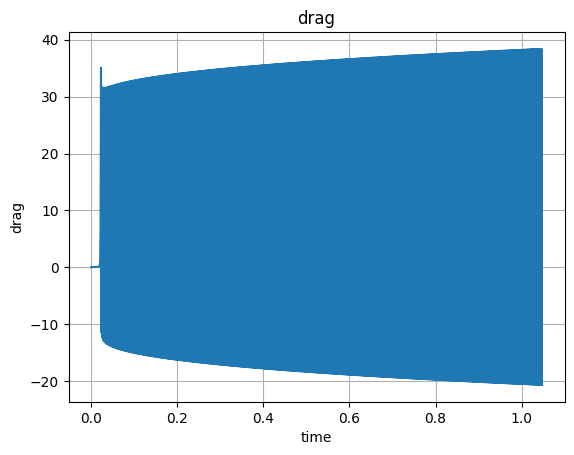

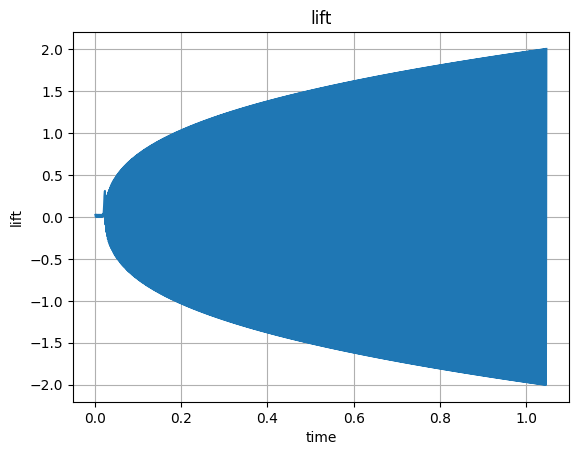

In [10]:
import os

outdir = r"D:\BaiduNetdiskDownload\seminar\ouputdir\Cylinder_Incremention_BDF2"
os.makedirs(outdir, exist_ok=True)  # 自动创建目录
file_path = os.path.join(outdir, "100_80_1000")
vtkout = VTKOutput(
    mesh,
    coefs = [gfu.components[0], gfu.components[1]],
    names = ["velocity", "pressure"],
    filename = file_path,
    subdivision = 2)

nframes = len(gfut.vecs)  # 多帧数量

for i in range(nframes):
    # 提取第i帧的解
    gfu.vec.data = gfut.vecs[i]  # 恢复到第i帧
    outname = vtkout.Do(time=i)
print("已写出：", outname)

import numpy as np

np.savez('cylinder_drag_lift.npz', time=time_vals, drag=drag_x_vals, lift=drag_y_vals)
# 加载方式
# data = np.load('cylinder_drag_lift.npz')
# drag = data['drag']
# lift = data['lift']

# 4. BDF2

## 4.1 BDF2一般形式

t= 4.999000000000004676

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

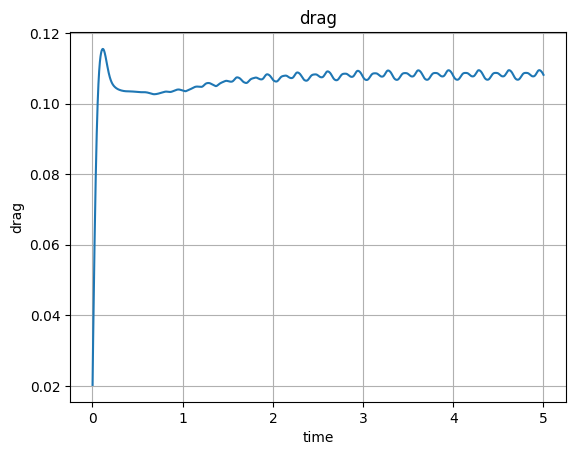

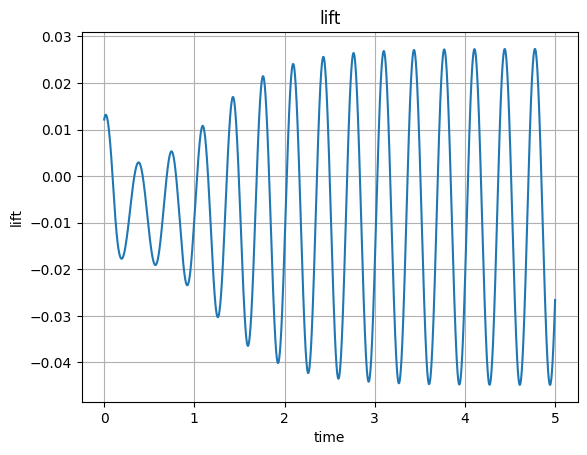

In [33]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/8)).Curve(3) # 三阶多项式拟合曲线
# n = specialcf.normal(mesh.dim)                       
n  = specialcf.normal(mesh.dim)        # 外法向
Id = Id(mesh.dim)                       # 单位张量  (或  Id(2)  )
rho = 1                                 # ρ=1 已隐含在 ν 里
D   = 0.1                               # 圆柱直径（用来算系数）
Uref = 1.5                              # 入口平均速度

# # 绘制物理域及计算域
# DrawGeo(shape); 
# Draw(mesh); # OCCGeometry会根据绘制图像复杂性生成不同粗细的网格拟合（如圆附近网格会更细）

nu = 0.001      
k = 3 # 空间阶数
dt = 0.001 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet")
Q = H1(mesh, order = k-1) # 未指明的边界默认为自然边界条件（在弱形式中会体现为零Neumann边界条件）
X = V * Q # 定义速度场与压力场的耦合空间

gfu = GridFunction(X) # 设置GridFunction作为解域，用于存储解作为后续初值使用
gfu_D = GridFunction(X)
gfu_mid = GridFunction(X)
gfu_old = GridFunction(X)
gfu_approximation = GridFunction(X)
velocity, pressure = gfu.components # X由V，P组成，gfu.components即为[V，P]
velocity_D, pressure_D = gfu_D.components
uin = CF((1.5*4*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
velocity_D.Set(uin, definedon = mesh.Boundaries("inlet"))

# # 分别绘制速度场和压力场处置
# Draw(velocity);
# Draw(pressure);

# 设置Trial和Test函数
(u,p),(v,q) = X.TnT()

a = BilinearForm((nu*InnerProduct(grad(u),grad(v)) - div(v)*p - div(u)*q)*dx).Assemble()
f = LinearForm(X).Assemble() # 默认为0

res = f.vec - a.mat * gfu_D.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu.vec.data = gfu_D.vec + inv_stokes * res

# # 绘制stokes的解（NS的初值）
# sceneu = Draw(velocity,mesh,"u")
# scenep = Draw(pressure,mesh,"p")

mstar = BilinearForm((1.5*InnerProduct(u, v) + dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())
r1 = BilinearForm(X, nonassemble = True)
r1 += dt * (- ((Grad(u) * u) * v)) * dx
r2 = BilinearForm(dt * (InnerProduct(u, v) * dx)).Assemble()
r3 = BilinearForm(InnerProduct(u, v) * dx).Assemble()
f = LinearForm(X).Assemble()

gfu_old.vec.data = gfu.vec
tmin = 1/1000000
a = BilinearForm((InnerProduct(u, v) + tmin * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
rhs = BilinearForm((InnerProduct(u, v) - tmin * (Grad(u) * u * v)) * dx).Assemble()
inva = a.mat.Inverse(X.FreeDofs())
res = rhs.mat * gfu.vec - a.mat * gfu_D.vec
gfu.vec.data = gfu_D.vec + inva * res

t = 0
i = 0
tend = 5
gfut = GridFunction(gfu.space,multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)
gfu1 = GridFunction(X)
gfu2 = GridFunction(X)
gfu3 = GridFunction(X)
gfu_n = GridFunction(X)

while t < tend - 0.5 * dt:
    print ("\rt=", t, end="")
    r1.Assemble()
    gfu_approximation.vec.data = 2 * gfu.vec - gfu_old.vec
    f.vec.data = r1.mat * gfu_approximation.vec
    gfu1.vec.data = inv * f.vec

    f.vec.data = r2.mat * gfu_approximation.vec
    gfu2.vec.data = inv * f.vec

    gfu_n.vec.data = 2 * gfu.vec - 0.5 * gfu_old.vec 
    f.vec.data = r3.mat * gfu_n.vec - mstar.mat * gfu_D.vec
    # f.vec.data = r3.mat * gfu.vec - dt * a.mat * gfu_D.vec
    gfu3.vec.data = gfu_D.vec + inv * f.vec
    
    # 当前速度
    velocity_approximation = gfu_approximation.components[0]
    velocity1 = gfu1.components[0]
    velocity2 = gfu2.components[0]
    velocity3 = gfu3.components[0]
    
    # 构造 F(uⁿ) = (u · ∇)u
    du = grad(velocity_approximation)
    F_un = CoefficientFunction((
        velocity_approximation[0]*du[0,0] + velocity_approximation[1]*du[0,1],
        velocity_approximation[0]*du[1,0] + velocity_approximation[1]*du[1,1]
    ))
    F_u = GridFunction(X)
    conv_u = F_u.components[0]
    conv_u.Set(F_un)

    # 计算每个项
    a11 = Integrate(InnerProduct(velocity_approximation, velocity_approximation), mesh) - Integrate(InnerProduct(velocity_approximation, velocity1), mesh)
    a12 = - Integrate(InnerProduct(velocity_approximation, velocity2), mesh)
    a21 = - Integrate(InnerProduct(F_un, velocity1), mesh)
    a22 = Integrate(InnerProduct(velocity_approximation, velocity), mesh) - Integrate(InnerProduct(F_un, velocity2), mesh)
    b1  = Integrate(InnerProduct(velocity_approximation, velocity3), mesh)
    b2  = Integrate(InnerProduct(F_un, velocity3), mesh) - Integrate(0.5 * InnerProduct(velocity_approximation, velocity_approximation) * InnerProduct(velocity_approximation, n), mesh, BND)
    # b2  = InnerProduct(conv_u.vec, velocity3.vec)
    # print(a11,a12,a21,a22)
    # print(b1,b2)
    
    alpha = (b1 * a22 - a12 * b2) / (a11 * a22 - a12 * a21)
    beta = (a11 * b2 - b1 * a21) / (a11 * a22 - a12 * a21)
    # print()
    # print(alpha, beta)
    # break
    gfu_old.vec.data = gfu.vec
    gfu.vec.data = alpha * gfu1.vec + beta * gfu2.vec + gfu3.vec
    
    mean_p = Integrate(pressure, mesh)
    domain_vol = Integrate(1, mesh)
    mean_val = mean_p / domain_vol
    
    # 2. 创建 offset 向量
    ones = pressure.vec.CreateVector()
    ones[:] = 1.0
    offset = mean_val * ones
    
    # 3. 减去 offset，实现零均值
    pressure.vec.data -= offset

    t = t + dt
    i += 1
    
    grad_v  = Grad(velocity)              # ∇u
    strain  = grad_v + grad_v.trans       # (∇u + ∇uᵀ)
    traction = -pressure * n + nu * (strain * n)   # σ·n
    
    FD = Integrate(traction[0], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 拖曳力
    FL = Integrate(traction[1], mesh,
                   definedon=mesh.Boundaries("cyl"))   # 升力
    
    drag_x_vals.append(FD)
    drag_y_vals.append(FL)
    time_vals.append(t)
    
    if i % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)

Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True, autoscale=False, vectors = True);
Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True, autoscale=False);

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

In [ ]:
import os

outdir = r"E:\seminar\ouputdir\Cylinder_BDF2"
os.makedirs(outdir, exist_ok=True)  # 自动创建目录
file_path = os.path.join(outdir, "1000_8_1000")
vtkout = VTKOutput(
    mesh,
    coefs = [gfu.components[0], gfu.components[1]],
    names = ["velocity", "pressure"],
    filename = file_path,
    subdivision = 2)

nframes = len(gfut.vecs)  # 多帧数量

for i in range(nframes):
    # 提取第i帧的解
    gfu.vec.data = gfut.vecs[i]  # 恢复到第i帧
    outname = vtkout.Do(time=i)
print("已写出：", outname)

import numpy as np

np.savez('cylinder_bdf2_drag_lift.npz', time=time_vals, drag=drag_x_vals, lift=drag_y_vals)
# 加载方式
# data = np.load('cylinder_drag_lift.npz')
# drag = data['drag']
# lift = data['lift']

## 4.2 BDF2增量形式

t= 24.99900000000757776

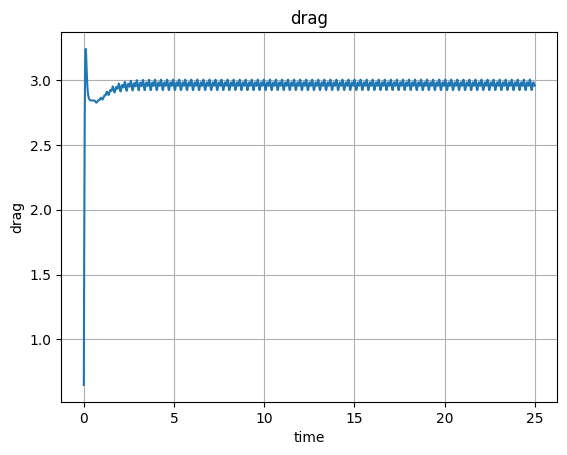

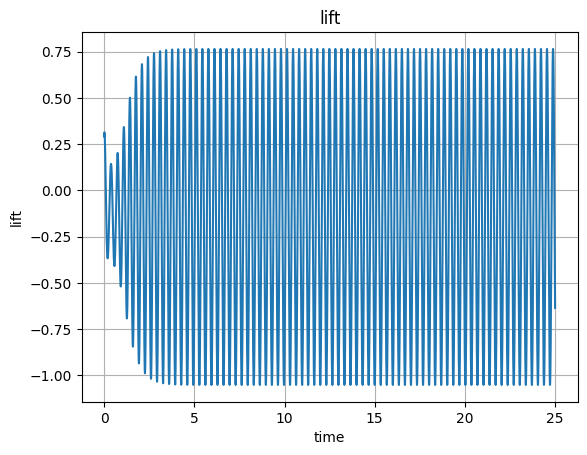

In [18]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/8)).Curve(3) # 三阶多项式拟合曲线

n  = specialcf.normal(mesh.dim)        # 外法向
Id = Id(mesh.dim)                       # 单位张量  (或  Id(2)  )
rho = 1                                 # ρ=1 已隐含在 ν 里
D   = 0.1                               # 圆柱直径（用来算系数）
Uref = 1.5                              # 入口平均速度

# # 绘制物理域及计算域
# DrawGeo(shape); 
# Draw(mesh); # OCCGeometry会根据绘制图像复杂性生成不同粗细的网格拟合（如圆附近网格会更细）

nu = 0.001      
k = 3 # 空间阶数
dt = 0.001 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet")
Q = H1(mesh, order = k-1) # 未指明的边界默认为自然边界条件（在弱形式中会体现为零Neumann边界条件）
X = V * Q # 定义速度场与压力场的耦合空间

gfu = GridFunction(X) # 设置GridFunction作为解域，用于存储解作为后续初值使用
gfu_mid = GridFunction(X)
gfu_old = GridFunction(X)
gfu_approximation = GridFunction(X)
velocity, pressure = gfu.components # X由V，P组成，gfu.components即为[V，P]
uin = CF((1.5*4*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
velocity.Set(uin, definedon = mesh.Boundaries("inlet"))

# gfu_D.vec.data.FV().NumPy()[X.FreeDofs()] = 0

drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

# # 分别绘制速度场和压力场处置
# Draw(velocity);
# Draw(pressure);

# 设置Trial和Test函数
(u,p),(v,q) = X.TnT()

a = BilinearForm((nu*InnerProduct(grad(u),grad(v)) - div(v)*p - div(u)*q)*dx).Assemble()
f = LinearForm(X).Assemble() # 默认为0

res = f.vec - a.mat * gfu.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu.vec.data += inv_stokes * res

# # 绘制stokes的解（NS的初值）
# sceneu = Draw(velocity,mesh,"u")
# scenep = Draw(pressure,mesh,"p")

mstar = BilinearForm((1.5*InnerProduct(u, v) + dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())
r1 = BilinearForm(X, nonassemble = True)
r1 += dt * (- ((Grad(u) * u) * v)) * dx
r2 = BilinearForm(dt * (InnerProduct(u, v) * dx)).Assemble()
r3 = BilinearForm(- dt * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q) * dx).Assemble()
conv = BilinearForm(X, nonassemble = True)
conv += ((Grad(u) * u) * v) * dx
m = BilinearForm((InnerProduct(u, v) * dx)).Assemble()
f = LinearForm(X).Assemble()

gfu_old.vec.data = gfu.vec
tmin = 1/1000000
a0 = BilinearForm((InnerProduct(u, v) + tmin * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q)) * dx).Assemble()
rhs = BilinearForm((-tmin * (nu * InnerProduct(grad(u),grad(v)) - div(v) * p - div(u) * q) - tmin * (Grad(u) * u * v)) * dx).Assemble()
inva = a0.mat.Inverse(X.FreeDofs())
res = rhs.mat * gfu.vec
gfu.vec.data += inva * res

t = 0
i = 0
tend = 25
gfut = GridFunction(gfu.space,multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)
gfu1 = GridFunction(X)
gfu2 = GridFunction(X)
gfu3 = GridFunction(X)
gfu_n = GridFunction(X)

while t < tend - 0.5 * dt:
    print ("\rt=", t, end="")
    conv.Assemble()
    r1.Assemble()
    gfu_approximation.vec.data = 2 * gfu.vec - gfu_old.vec
    f.vec.data = r1.mat * gfu_approximation.vec
    gfu1.vec.data = inv * f.vec

    f.vec.data = r2.mat * gfu_approximation.vec
    gfu2.vec.data = inv * f.vec

    gfu_n.vec.data = 0.5 * gfu.vec - 0.5 * gfu_old.vec
    f.vec.data = r3.mat * gfu.vec + m.mat * gfu_n.vec
    # f.vec.data = r3.mat * gfu.vec - dt * a.mat * gfu_D.vec
    gfu3.vec.data = gfu.vec + inv * f.vec
    
    # 当前速度
    velocity_approximation = gfu_approximation.components[0]
    velocity1 = gfu1.components[0]
    velocity2 = gfu2.components[0]
    velocity3 = gfu3.components[0]
    
    # 构造 F(uⁿ) = (u · ∇)u
    du = grad(velocity_approximation)
    F_un = CoefficientFunction((
        velocity_approximation[0]*du[0,0] + velocity_approximation[1]*du[0,1],
        velocity_approximation[0]*du[1,0] + velocity_approximation[1]*du[1,1]
    ))
    F_u = GridFunction(X)
    conv_u = F_u.components[0]
    conv_u.Set(F_un)

    # 计算每个项
    a11 = Integrate(InnerProduct(velocity_approximation, velocity_approximation), mesh) - Integrate(InnerProduct(velocity_approximation, velocity1), mesh)
    a12 = - Integrate(InnerProduct(velocity_approximation, velocity2), mesh)
    a21 = - Integrate(InnerProduct(F_un, velocity1), mesh)
    a22 = Integrate(InnerProduct(velocity_approximation, velocity), mesh) - Integrate(InnerProduct(F_un, velocity2), mesh)
    b1  = Integrate(InnerProduct(velocity_approximation, velocity3), mesh)
    b2  = Integrate(InnerProduct(F_un, velocity3), mesh) - Integrate(0.5 * InnerProduct(velocity_approximation, velocity_approximation) * InnerProduct(velocity_approximation, n), mesh, BND)
    # b2  = InnerProduct(conv_u.vec, velocity3.vec)
    # print(a11,a12,a21,a22)
    # print(b1,b2)
    
    alpha = (b1 * a22 - a12 * b2) / (a11 * a22 - a12 * a21)
    beta = (a11 * b2 - b1 * a21) / (a11 * a22 - a12 * a21)
    # print()
    # print(alpha, beta)
    # break
    gfu_old.vec.data = gfu.vec
    gfu.vec.data = alpha * gfu1.vec + beta * gfu2.vec + gfu3.vec
    
    # mean_p = Integrate(pressure, mesh)
    # domain_vol = Integrate(1, mesh)
    # mean_val = mean_p / domain_vol
    
    # # 2. 创建 offset 向量
    # ones = pressure.vec.CreateVector()
    # ones[:] = 1.0
    # offset = mean_val * ones
    
    # # 3. 减去 offset，实现零均值
    # pressure.vec.data -= offset

    t = t + dt
    i += 1
    
    res = (a.mat + conv.mat) * gfu.vec
    drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
    drag_y_vals.append(InnerProduct(res, drag_y_test.vec) )
    time_vals.append(t)
    
    if i % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)

# Draw (gfut.components[0], mesh, interpolate_multidim=True, animate=True, autoscale=False, vectors = True);
# Draw (gfut.components[1], mesh, interpolate_multidim=True, animate=True, autoscale=False);

# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()

In [4]:
import os

outdir = r"E:\seminar\ouputdir\Cylinder_Incremention_BDF2"
os.makedirs(outdir, exist_ok=True)  # 自动创建目录
file_path = os.path.join(outdir, "1000_8_1000")
vtkout = VTKOutput(
    mesh,
    coefs = [gfu.components[0], gfu.components[1]],
    names = ["velocity", "pressure"],
    filename = file_path,
    subdivision = 2)

nframes = len(gfut.vecs)  # 多帧数量

for i in range(nframes):
    # 提取第i帧的解
    gfu.vec.data = gfut.vecs[i]  # 恢复到第i帧
    outname = vtkout.Do(time=i)
print("已写出：", outname)

import numpy as np

np.savez('cylinder_bdf2_drag_lift.npz', time=time_vals, drag=drag_x_vals, lift=drag_y_vals)
# 加载方式
# data = np.load('cylinder_drag_lift.npz')
# drag = data['drag']
# lift = data['lift']

已写出： E:\seminar\ouputdir\Cylinder_Incremention_BDF2\1000_8_1000_step00250


# 5. 投影法

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/8)).Curve(3) # 三阶多项式拟合曲线 

n  = specialcf.normal(mesh.dim)       
Id = Id(mesh.dim)                     
rho = 1                               
D   = 0.1                             
Uref = 1.5

nu = 0.001
k = 3 # 空间阶数
dt = 0.001 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet")
Q = H1(mesh, order = k-1)

u,v = V.TnT()
p,q = Q.TnT()

gfu = GridFunction(V)
gfu_D = GridFunction(V)
gfu_old = GridFunction(V)
gfu_approximation = GridFunction(V)
gfu_pre = GridFunction(V)
gfu_temp = GridFunction(V)
correction = GridFunction(V)
gfu_p = GridFunction(Q)
gfu_ptemp = GridFunction(Q)

uin = CF((1.5*4*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
gfu_D.Set(uin, definedon = mesh.Boundaries("inlet"))

gfu_old.vec.data = gfu_D.vec + gfu.vec

tmin = 1/1000000
a1 = BilinearForm((InnerProduct(u, v) + tmin * nu * InnerProduct(grad(u),grad(v))) * dx).Assemble()
inv1 = a1.mat.Inverse(V.FreeDofs())
r1 = BilinearForm((InnerProduct(u, v) - tmin * (Grad(u) * u) * v ) * dx).Assemble()
f1 = LinearForm(tmin * InnerProduct(gfu_p,div(v)) * dx).Assemble()

a2 = BilinearForm(InnerProduct(grad(p), grad(q)) * dx).Assemble()
inv2 = a2.mat.Inverse(Q.FreeDofs())
f2 = LinearForm(- 1/tmin * InnerProduct(div(gfu),q) * dx).Assemble()
rhs =  r1.mat * gfu.vec + f1.vec - a1.mat * gfu_D.vec
gfu.vec.data = gfu_D.vec + inv1 * rhs

gfu_ptemp.vec.data = inv2 * f2.vec
gfu_p.vec.data += gfu_ptemp.vec

correction.Set(grad(gfu_ptemp))
gfu_pre.vec.data = gfu.vec   

gfu.vec.data = gfu_pre.vec - dt * correction.vec
mean_p = Integrate(gfu_p, mesh)
domain_vol = Integrate(1, mesh)
mean_val = mean_p / domain_vol

# 2. 创建 offset 向量
ones = gfu_p.vec.CreateVector()
ones[:] = 1.0
offset = mean_val * ones

# 3. 减去 offset，实现零均值
gfu_p.vec.data -= offset

a1 = BilinearForm((1.5*InnerProduct(u, v) + dt * nu * InnerProduct(grad(u),grad(v))) * dx).Assemble()
inv1 = a1.mat.Inverse(V.FreeDofs())
conv = BilinearForm(V,nonassemble = True)
conv += (- dt * (Grad(u) * u) * v) * dx
f1 = LinearForm(V,nonassemble = True)
# f1 += (2 * InnerProduct(gfu, v) - 0.5 * InnerProduct(gfu_old, v) + dt * (2 * InnerProduct(gfu_p,div(v)) -  InnerProduct(gfu_p_old,div(v)))) * dx
f1 += (2 * InnerProduct(gfu, v) - 0.5 * InnerProduct(gfu_old, v) + dt * InnerProduct(gfu_p,div(v))) * dx
a2 = BilinearForm(InnerProduct(grad(p), grad(q)) * dx).Assemble()
inv2 = a2.mat.Inverse(Q.FreeDofs())
f2 = LinearForm(Q,nonassemble = True)
f2 +=  (- 1.5/dt * (InnerProduct(div(gfu_pre),q))) * dx

t = 0
i = 0
tend = 5
gfut = GridFunction(gfu.space,multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)

while t < tend - 0.5*dt:
    conv.Assemble()
    f1.Assemble()
    gfu_temp.vec.data = 2 * gfu.vec - gfu_old.vec
    rhs =  conv.mat * gfu_temp.vec + f1.vec - a1.mat * gfu_D.vec
    gfu_pre.vec.data = gfu_D.vec + inv1 * rhs
    
    # Draw(gfu)
    
    f2.Assemble()
    gfu_ptemp.vec.data = inv2 * f2.vec
    gfu_p_old.vec.data = gfu_p.vec
    gfu_p.vec.data += gfu_ptemp.vec
    
    correction = GridFunction(V)
    correction.Set(grad(gfu_ptemp))
    gfu_old.vec.data = gfu.vec
    gfu.vec.data = gfu_pre.vec - 2/3*dt * correction.vec
    mean_p = Integrate(gfu_p, mesh)
    domain_vol = Integrate(1, mesh)
    mean_val = mean_p / domain_vol
    
    # 2. 创建 offset 向量
    ones = gfu_p.vec.CreateVector()
    ones[:] = 1.0
    offset = mean_val * ones
    
    # 3. 减去 offset，实现零均值
    gfu_p.vec.data -= offset
    # print(gfu.vec.data)
    # break
    t += dt
    

NameError: name 'gfu_temp' is not defined

In [41]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/8)).Curve(3) # 三阶多项式拟合曲线
# n = specialcf.normal(mesh.dim)                       
n  = specialcf.normal(mesh.dim)        # 外法向
Id = Id(mesh.dim)                       # 单位张量  (或  Id(2)  )
rho = 1                                 # ρ=1 已隐含在 ν 里
D   = 0.1                               # 圆柱直径（用来算系数）
Uref = 1.5                              # 入口平均速度

# # 绘制物理域及计算域
# DrawGeo(shape); 
# Draw(mesh); # OCCGeometry会根据绘制图像复杂性生成不同粗细的网格拟合（如圆附近网格会更细）

nu = 0.001      
k = 3 # 空间阶数
dt = 0.001 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet")
Q = H1(mesh, order = k-1) # 未指明的边界默认为自然边界条件（在弱形式中会体现为零Neumann边界条件）
X = V * Q # 定义速度场与压力场的耦合空间

gfu0 = GridFunction(X) # 设置GridFunction作为解域，用于存储解作为后续初值使用
gfu_mid = GridFunction(X)
gfu_old = GridFunction(X)
gfu_approximation = GridFunction(X)
velocity, pressure = gfu0.components # X由V，P组成，gfu.components即为[V，P]
uin = CF((1.5*4*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
velocity.Set(uin, definedon = mesh.Boundaries("inlet"))

# 设置Trial和Test函数
(u,p),(v,q) = X.TnT()

a = BilinearForm((nu*InnerProduct(grad(u),grad(v)) - div(v)*p - div(u)*q)*dx).Assemble()
f = LinearForm(X).Assemble() # 默认为0

res = f.vec - a.mat * gfu0.vec
inv_stokes = a.mat.Inverse(X.FreeDofs())
gfu0.vec.data += inv_stokes * res

mean_p = Integrate(pressure, mesh)
domain_vol = Integrate(1, mesh)
mean_val = mean_p / domain_vol

# 2. 创建 offset 向量
ones = pressure.vec.CreateVector()
ones[:] = 1.0
offset = mean_val * ones

# 3. 减去 offset，实现零均值
pressure.vec.data -= offset

Draw(gfu0.components[0])

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [42]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

shape = Rectangle(2.2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()  # 先绘制一个矩形，再在(0.2,0.2)位置绘制圆，并Reverse使其为interface
shape.edges.name = "cyl" # 圆形表面
shape.edges.Max(X).name = "outlet"
shape.edges.Min(X).name = "inlet"
shape.edges.Max(Y).name = "wall"
shape.edges.Min(Y).name = "wall"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh = 1/8)).Curve(3) # 三阶多项式拟合曲线 

# n  = specialcf.normal(mesh.dim)       
# Id = Id(mesh.dim)                     
# rho = 1                               
# D   = 0.1                             
# Uref = 1.5

nu = 0.001
k = 3 # 空间阶数
dt = 0.001 # 定义时间步长
t = 0
i = 0
time_vals, drag_x_vals, drag_y_vals = [],[],[]

V = VectorH1(mesh, order = k, dirichlet = "wall|cyl|inlet")
Q = H1(mesh, order = k-1)

u,v = V.TnT()
p,q = Q.TnT()

i = 0
tend = 1
# 初始速度和压力
gfu = GridFunction(V)
gfu_D = GridFunction(V)
gfu_p = GridFunction(Q)
gfu_pre = GridFunction(V)
gfu_ptemp = GridFunction(Q)

uin = CF((1.5*4*y*(0.41-y)/(0.41**2),0)) # CF为系数矩阵
gfu_D.Set(uin, definedon = mesh.Boundaries("inlet"))
# Draw(gfu_D)
gfu.vec.data = gfu0.components[0].vec
gfu_p.vec.data = gfu0.components[1].vec
# Draw(gfu_p)
a1 = BilinearForm((InnerProduct(u, v) + dt * nu * InnerProduct(grad(u),grad(v))) * dx).Assemble()
inv1 = a1.mat.Inverse(V.FreeDofs())
r1 = BilinearForm(V,nonassemble = True)
r1 += (InnerProduct(u, v) - dt * (Grad(u) * u) * v ) * dx
f1 = LinearForm(V,nonassemble = True)
f1 += dt * InnerProduct(gfu_p,div(v)) * dx
a2 = BilinearForm(InnerProduct(grad(p), grad(q)) * dx).Assemble()
inv2 = a2.mat.Inverse(Q.FreeDofs())
f2 = LinearForm(Q,nonassemble = True)
f2 +=  - 1/dt * InnerProduct(div(gfu_pre),q) * dx

t = 0
i = 0
tend = 1
gfut = GridFunction(gfu.space,multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)

while t < tend - 0.5*dt:
    print ("\rt=", t, end="")
    r1.Assemble()
    f1.Assemble()
    rhs =  r1.mat * gfu.vec + f1.vec - a1.mat * gfu_D.vec
    gfu_pre.vec.data = gfu_D.vec + inv1 * rhs
    Draw(gfu_pre)
    
    f2.Assemble()
    gfu_ptemp.vec.data = inv2 * f2.vec
    
    mean_p = Integrate(gfu_ptemp, mesh)
    domain_vol = Integrate(1, mesh)
    mean_val = mean_p / domain_vol
    # 2. 创建 offset 向量
    ones = gfu_ptemp.vec.CreateVector()
    ones[:] = 1.0
    offset = mean_val * ones
    # 3. 减去 offset，实现零均值
    gfu_ptemp.vec.data -= offset
    
    gfu_p.vec.data += gfu_ptemp.vec
    
    Draw(gfu_ptemp)
    # Draw(gfu_p)
    correction = GridFunction(V)
    correction.Set(grad(gfu_ptemp))
    
    gfu.vec.data = gfu_pre.vec - dt * correction.vec
    
    # Draw(gfu)
    if i == 5:
        break
    if i % 100 == 0:
        gfut.AddMultiDimComponent(gfu.vec)
    t += dt
    i += 1

# Draw (gfut, mesh, interpolate_multidim=True, animate=True, autoscale=False, vectors = True);

t= 0

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

t= 0.001

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

t= 0.002

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

t= 0.003

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

t= 0.004

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

t= 0.005

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…